In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data()

In [ ]:
# display data
# print(y_train[0])
# plt.imshow(X_train[0], cmap='Greys')

In [ ]:
def compute_loss(y, tx, w):
    """ Compute loss by MSE."""
    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

In [ ]:
def create_mini_batches(X, y, batch_size=256):
    mini_batches = []
    data = np.column_stack((np.array([x.ravel() for x in X_train]), y_train))
    np.random.shuffle(data)
    n_mini_batches = data.shape[0] // batch_size
    count = 0
    for i in range(n_mini_batches + 1):
        mini_batch = data[i * batch_size:min((i + 1) * batch_size, data.shape[0]), :]
        X_mini_batch = np.array([x.reshape((28, 28)) for x in mini_batch[:, :-1]])
        y_mini_batch = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini_batch, y_mini_batch))
    return mini_batches

In [ ]:
w = np.zeros((X.shape[1], 1))
error_list = []
n_iter = 100

for i in range(n_iter):
    mbatches = create_mini_batches(X_train, y_train)
    for mbatch in mbatches:
        X_mbatch, y_mbatch = mbatch
        w -= learning_rate * gradient(X_mbatch, y_mbatch, w)
        error_list.append(compute_loss(X_mbatch, y_mbatch, w))

#### PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale

In [197]:
df = pd.read_csv('data/train.csv')
y = df['label'].values
X = df.drop(['label'],1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# standardize dataset
X_train = scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = scale(X_test, axis=1, with_mean=True, with_std=True)

batch_size = 64

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test, torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

C:\Users\Mariko\Anaconda3\envs\py3.7\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mariko\Anaconda3\envs\py3.7\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# batch_size = 64

# train_loader = DataLoader(
#     torchvision.datasets.MNIST('/files/', train=True, download=True,
#                                transform=torchvision.transforms.Compose([
#                                    torchvision.transforms.ToTensor(),
#                                    torchvision.transforms.Normalize(
#                                        (0.1307,), (0.3015,))])),
#     batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.MNIST('/files/', train=False, download=True,
#                                transform=torchvision.transforms.Compose([
#                                    torchvision.transforms.ToTensor(),
#                                    torchvision.transforms.Normalize(
#                                        (0.1325,), (0.3039,))])),
#     batch_size=1000, shuffle=True)

In [198]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
        self.layers = [self.linear1, self.linear2, self.linear3]
    
    def forward(self, X):
        X = torch.tensor(X, dtype=torch.float)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

In [318]:
losses_dict = dict()

In [246]:
model = MLP()
lr = 0.01
optimizers = {
    'sgd0.9': torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True),
    'sgd0.5': torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5),
    'adam': torch.optim.Adam(model.parameters(), lr=lr),
    'adadelta': torch.optim.Adadelta(model.parameters(), lr=lr),
    'rmsprop': torch.optim.RMSprop(model.parameters(), lr=lr)
}

In [247]:
# model = MLP()
losses = []
# wbs = [(l.weight, l.bias) for l in model.layers]

epochs = 5
criterion = nn.NLLLoss()

In [374]:
all_losses = []
nb_models = 10
nb_epochs = 5
for i in range(nb_models):
    model = MLP()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    losses = []
    print('Training model', i)
    for epoch in range(nb_epochs):
        print('  Epoch', epoch)
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if epoch % 10 == 0:
                losses.append(loss.item())
            loss.backward()
            optimizer.step()
    all_losses.append(losses)

Training model 0
  Epoch 0


C:\Users\Mariko\Anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 1
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 2
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 3
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 4
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 5
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 6
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 7
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 8
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4
Training model 9
  Epoch 0
  Epoch 1
  Epoch 2
  Epoch 3
  Epoch 4


In [375]:
losses = np.array(all_losses).mean(axis=0)

In [376]:
len(losses)

525

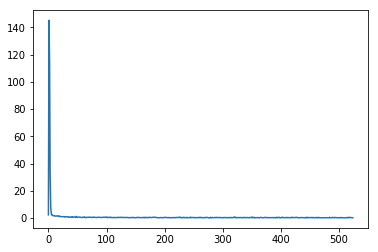

In [383]:
plt.plot(losses)

In [384]:
losses_dict['rmsprop'] = losses

In [385]:
l = losses_dict.copy()

In [275]:
for i in range(5):
    l['rmsprop'][i] = 3

In [386]:
colors = ['blue', 'green', 'red', 'orange', 'purple']

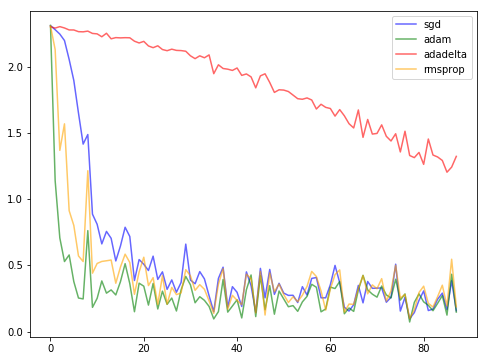

In [396]:
plt.figure(figsize=(8, 6))
i = 0
for k, v in l.items():
    values = [x for j, x in enumerate(v) if j % 6 == 0]
    plt.plot(values, label=k, alpha=0.6, color=colors[i])
    i += 1
plt.legend()
plt.show()

In [ ]:
# adabound

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            l = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), l))
            train_losses.append(l)

In [ ]:
model = Net()
optimizer = torch.optim.Adam(model.parameters()) # lr=lr, momentum=momentum)
train_losses = []

for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)

In [ ]:
plt.plot(train_losses)

In [ ]:
train_losses_dict = dict()
train_losses_dict['sgd'] = train_losses